# Что мы узнаем сегодня?


1. [Как работать с пропусками в данных](#Пропуски-в-данных)
2. [Как работать с категориальными признаками](#Категориальные-признаки)
3. [Полезные преобразования данных](#Полезные-преобразования-данных)
4. [Инжинирим признаки](#Инжинирим-признаки)
5. [Поговорим про отбор признаков](#Отбор-признаков)
6. [KaggleInClass](#KaggleInClass)

# Пропуски в данных

Рассмотрим датасет `communities and crime`. Этот датасет содержит различные признаки, которые характеризуют район. Задача предсказать уровень преступности на 100 тысяч человек. Это задача регрессии.

In [3]:
import numpy as np
import pandas as pd

# Датасет взят отсюда: http://archive.ics.uci.edu/ml/datasets/communities+and+crime
# Загружаем датасет

x = pd.read_csv('communites.csv',delimiter=',')

In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Columns: 128 entries, 8 to 0.2.2
dtypes: float64(100), int64(2), object(26)
memory usage: 1.9+ MB


Итак, у нас 1994 района и 122 признака, `ViolentCrimesPerPop` наша таргетная переменная.

Давайте взглянем на данные:

In [5]:
# Посмотрим на данные:
x.head()

,8,?,?.1,Lakewoodcity,1,0.19,0.33,0.02,0.9,0.12,...,0.12.2,0.26.1,0.2.1,0.06.3,0.04.2,0.9.1,0.5.2,0.32.2,0.14.3,0.2.2
0,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.0,?,0.67
1,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.0,?,0.43
2,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.0,?,0.12
3,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.0,?,0.03
4,6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,?,?,?,?,0.0,?,0.14


Видим глазами много пропусков. А как узнать сколько значений не известно?

In [6]:
x.isna().any().sum() # сколько признаков содержат неизвестные значения

0

In [7]:
x.isna().sum()[-10:] # cколько неизвестных значений содержит каждый признак

0.12.2    0
0.26.1    0
0.2.1     0
0.06.3    0
0.04.2    0
0.9.1     0
0.5.2     0
0.32.2    0
0.14.3    0
0.2.2     0
dtype: int64

In [8]:
# Выведите одно число -- количество пропущенных значений

x.isna().values.sum()

0

**Как быть?**


**Удалить лишнее**
* Выкинуть данные с неизвестным признаком
* Выкинуть признак, если он имеет слишком мало известных значений

**Восстановить значения**

*В англоязычной терминологии это называется `imputation`.*
    
   * Для **вещественных** признаков
    * Заполнить все пропуски средним (модой, медианой) значениями признака
    * Предсказывать значение пропущенного признака с помощью линейной регрессии
   * Для **категориальных**
    * Отдельное значением типа "n/a"
    * Использовать самое частое значение признака


Хорошая идея также добавить отдельный признак `A_missing` и присваивать ему значение `1` всякий раз, когда значение признака `A` пропущено.

Более подробно можно почитать [здесь](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4).

In [9]:
# Заполняем все пропуски в данных средними значениями для каждого признака
from sklearn import impute

mis_replacer = impute.SimpleImputer(missing_values='?', strategy='most_frequent')
x = pd.DataFrame(data=mis_replacer.fit_transform(x), columns=x.columns)

In [10]:
# Aльтернатива через pandas
# Подробнее в описании функции

x.fillna(value=0, inplace=True)

In [11]:
# Теперь можно проверить снова сколько у нас пропущенных данных
# Выведите одно число -- количество пропущенных значений

x.isna().values.sum()

0

---

# Категориальные признаки

Для примера создадим небольшую табличку

In [12]:
import pandas as pd

# просто табличка для примера
def create_data():
    return (pd.DataFrame({'city': ['Moscow', 'London', 'London', 'Kiev',
                                   'Moscow', 'Moscow', 'Kiev','Moscow'],
                          'degree': [1, 1, 2, 2, 3, 3, 1, 1],
                          'class':['A','B','A','A','B','B','A','A'],
                          'income':[10.2, 11.6, 8.8, 9.0, 6.6, 10.0, 9.0, 7.2]}))

data = create_data()
data

,city,degree,class,income
0,Moscow,1,A,10.2
1,London,1,B,11.6
2,London,2,A,8.8
3,Kiev,2,A,9.0
4,Moscow,3,B,6.6
5,Moscow,3,B,10.0
6,Kiev,1,A,9.0
7,Moscow,1,A,7.2


###  Как понять, что признак категориальный?

Идея - категориальные признаки те, в которых значения - строки или число уникальных значений достаточно мало.

In [13]:
# найти все признаки, в которых первое значение - строка 
def find_cat(data, num_uniq=4):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique()<=num_uniq):
            s += ' мало уникальных'
        if (s!=name):
            print (s)
            
find_cat(data)

city строка, мало уникальных
degree мало уникальных
class строка, мало уникальных


### Как подавать категориальные признаки алгоритму?

Алгоритмы хотят, чтобы им на вход подавали числа, а не строки. Кроме того, большая часть алгоритмов машинного обучения тем или иным образом использует понятие расстояния между точками. Поэтому приходится подумать как же так представить категориальный признак, чтобы все заработало.

Существует как минимум *2 популярных подхода*:

1) Самый простой подход **one-hot кодирование**.
Выглядит это так


Этот способ наиболее универсален и применяется по умолчанию. Универсальность здесь означает -- возможность использования такого представления в любом алгоритме машинного обучения.

Теперь посмотрите на картинку. Если еще не стало понятно, то вот пояснение.

Суть в том, что каждое значение категориального признака порождает свой собственный признак. Далее, кодируем нулями и единицами отсутствие или наличие соответствующего признака.


In [14]:
# Очень просто с помощью pandas
# Заметим при этом, что `degree` и `income` остались неизменными.
pd.get_dummies(data)

,degree,income,city_Kiev,city_London,city_Moscow,class_A,class_B
0,1,10.2,0,0,1,1,0
1,1,11.6,0,1,0,0,1
2,2,8.8,0,1,0,1,0
3,2,9.0,1,0,0,1,0
4,3,6.6,0,0,1,0,1
5,3,10.0,0,0,1,0,1
6,1,9.0,1,0,0,1,0
7,1,7.2,0,0,1,1,0


Если хочется больше гибкости, можно попробовать для тех же целей воспользоваться `OneHotEncoder` из `sklearn.preprocessing`

2) **Группируем числовые признаки по категориальным**

Например, для каждого значения признака `city` из нашей таблички можно посчитать среднее значение `income`.

In [15]:
# функция возвращает значения нового признака
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

data = create_data()
data['city_mean_income'] = code_mean(data, 'city', 'income')
data[:6]

,city,degree,class,income,city_mean_income
0,Moscow,1,A,10.2,8.5
1,London,1,B,11.6,10.2
2,London,2,A,8.8,10.2
3,Kiev,2,A,9.0,9.0
4,Moscow,3,B,6.6,8.5
5,Moscow,3,B,10.0,8.5


In [16]:
code_mean(data, 'city', 'income')

0     8.5
1    10.2
2    10.2
3     9.0
4     8.5
5     8.5
6     9.0
7     8.5
Name: city, dtype: float64

### Дата и время

Для примера рассмотрим датасет UFO (оригинальная полная версия датасета находится [здесь](https://www.kaggle.com/NUFORC/ufo-sightings)) в котором для каждого события известна дата и конкретное время

In [17]:
df = pd.read_csv("ufo.csv")
df.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [18]:
# посмотрим типы столбцов в таблице
df.dtypes 

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object

In [19]:
# Переводим Time в формат времени
# Теперь для столбца "Time" тип изменился
#df['dateime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
#df.insert(1, 'year', df['datetime'].dt.year)
df.dtypes
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556


Правильный формат данных для хранения даты времени позволяет сразу получать категориальные признаки

In [20]:
# Какой час
df['datetime'] = df['datetime'].str.replace(' 24:', ' 00:', regex=False)
df['datetime'] = pd.to_datetime(df.datetime, format='%m/%d/%Y %H:%M')
df['datetime'].dt.hour.head()

0    20
1    21
2    17
3    21
4    20
Name: datetime, dtype: int64

In [21]:
# Название дня недели
df['datetime'].dt.day_name().head() 

0       Monday
1       Monday
2       Monday
3    Wednesday
4       Monday
Name: datetime, dtype: object

In [22]:
# Является ли этот день выходным
df['is_weekend'] = df['datetime'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

In [23]:
df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,is_weekend
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,0
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,0
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,0
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,0
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,0


* **Проекция на окружность и использованием 2х координат**

Использование более эзотерических подходов для нормализации значения времени.

---
**Идея взята из курса [ml course open](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a)

In [24]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

make_harmonic_features(12)

(-1.0, 1.2246467991473532e-16)

### Геоданные

Возможно находить строковый адрес по данным координатам локации, однако это требует большой аккуратности в интерпретации и чистке полученных значений.


---
**Идея взята из курса [ml course open](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a)

In [25]:
#!pip install reverse_geocoder

In [26]:
import reverse_geocoder as revgc
revgc.search((40.74482, -73.94875))

Loading formatted geocoded file...


[{'lat': '40.74482',
  'lon': '-73.94875',
  'name': 'Long Island City',
  'admin1': 'New York',
  'admin2': 'Queens County',
  'cc': 'US'}]

---

# Полезные преобразования данных

Иногда числовые значения признаков хорошо бы привести к другим значениям с помощью преобразований. Очень часто это может улучшить результаты некоторых алгоритмов. Такие алгоритмы, как правило, делают некоторые предположения о характере данных или же опираются на расстояния между элементами выборки.


**Популярные преобразования**

(1) **Z-score**
$$\large z(x) = \frac{x - \mu}{\sigma}$$

* Полезно, если существенно расстояние между точками (например в knn)
* Это преобразование линейное, оно не меняет распределение данных

In [27]:
# Есть в sklearn
from sklearn.preprocessing import StandardScaler

In [28]:
# Обратим внимание на значение 100
data = np.array([1, 1, 0, -1, 2, 3, -2, 4, 100], dtype=np.float32).reshape(-1,1)
StandardScaler().fit_transform(data)

array([[-0.3529866 ],
       [-0.3529866 ],
       [-0.38507628],
       [-0.417166  ],
       [-0.32089692],
       [-0.2888072 ],
       [-0.44925568],
       [-0.25671753],
       [ 2.8238928 ]], dtype=float32)

In [29]:
# Это то же самое, что сделать это руками:
(data - data.mean()) / data.std()

array([[-0.3529866 ],
       [-0.3529866 ],
       [-0.3850763 ],
       [-0.417166  ],
       [-0.32089692],
       [-0.28880724],
       [-0.44925568],
       [-0.25671753],
       [ 2.8238928 ]], dtype=float32)

   ---
   (2) **MinMax Scaling**
    
Другой достаточно популярный вариант – MinMax Scaling, который переносит все точки на заданный отрезок (обычно (0, 1))
$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

* Полезно, если хочется оценить влияние признака по весам в линейной регрессии
* Можно перенести значение признака в интервал (0, 255) для визуализации

В целом, оба варианта часто взаимозаменяемы.

In [30]:
# Демонстрация
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler().fit_transform(data)

array([[0.02941177],
       [0.02941177],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.0000001 ]], dtype=float32)

In [31]:
(data - data.min()) / (data.max() - data.min())

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]], dtype=float32)

(3) **Логарифмирование**

~~(как способ бороться с тяжелыми хвостами)~~


* Существует ряд преобразований, которые позволяют из распределения с "тяжелым хвостом" (в английском варианте long tail) сделать распределение похожее на нормальное. 

* Нормальное распределение нравится многим алгоритмам машинного обучения и такое преобразование иногда может улучшить ситуацию.


In [32]:
# Настраиваем параметры отрисовки графиков
%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

Populating the interactive namespace from numpy and matplotlib


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


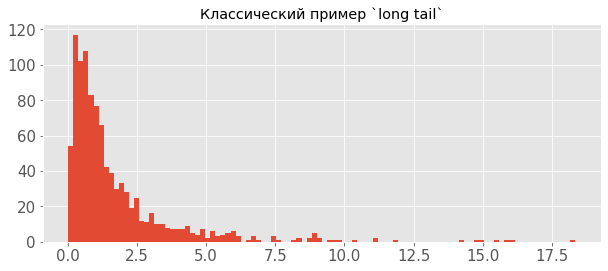

In [33]:
from scipy.stats import lognorm

# сгенерируем себе выборку

data = lognorm(s=1).rvs(1000)
plt.hist(data, bins=100)
plt.title("Классический пример `long tail`")
plt.show()

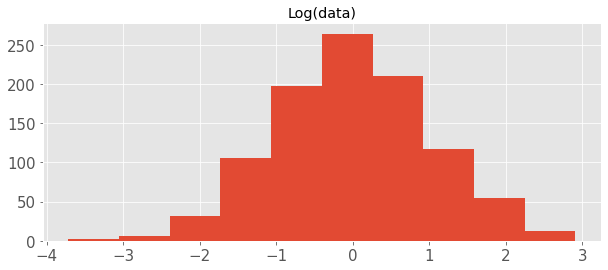

In [34]:
# А вот так выглядят данные после логарифмирования

plt.hist(np.log(data))
plt.title("Log(data)")
plt.show()

---

# Инжинирим признаки


Как помочь нашей модели найти полезные зависимости в данных?

Можно условно поделить генерацию признаков на **две части**:
 1. Создание признаков **на основе знаний** и житейского опыта
 2. Создание различных **взаимодействий** признаков
 

### Полиномиальные признаки

Почему готовить новые признаки это хорошо?

**XOR проблема**

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:



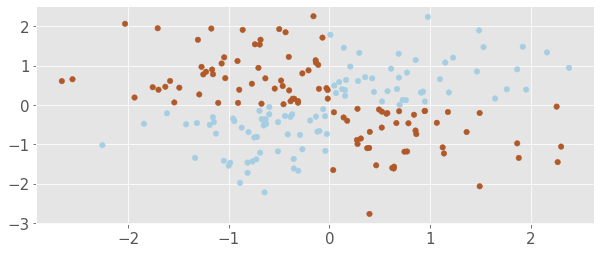

In [35]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
plt.show()

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Функция рисует плоскость согласно предсказаниям классификатора clf
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

In [38]:
from sklearn.linear_model import LogisticRegression

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


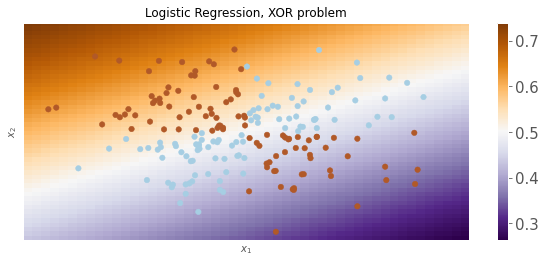

In [39]:
# Применяем логистическую регрессию к нашим данным
# И видим, что линейная модель не способна разделить точки правильно
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

### Что мы делаем?
Добавляем полиномиальные признаки!

Т.е. получаем несколько признаков из данных путем их возведения в степень и перемножения между собой.

**Пример с двумерными данными, degree*=2**

**degree - максимальная сумма степеней множителей-признаков в отдельно полученном новом признаке*

$$\Large (a, b) \rightarrow (1, a, b, a^2, ab, b^2)$$

Удобно, что sklearn уже умеет генерировать полиномиальные признаки для нас

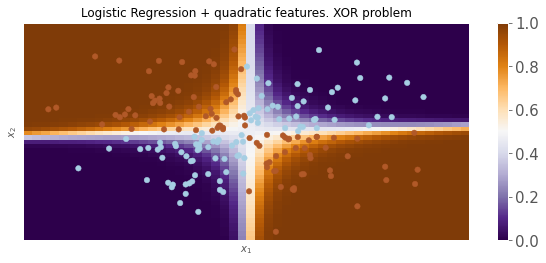

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Очень часто удобно использовать Pipeline
# для последовательного применения алгоритмов из sklearn
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])
plot_boundary(logit_pipe, X, y,
        "Logistic Regression + quadratic features. XOR problem")

# Проблема решается!

### Применение житейской смекалки
для создания признаков



Есть количество комнат и стоимость аренды

Выделяем новый признак -- стоимость аренды одной комнаты:
```python
rooms = df["bedrooms"]
df["price_per_bedroom"] = df["price"] / rooms
```

# Отбор признаков

1. Чисто статистическими методами
2. С использованием моделей
3. Перебором

## Статистические методы

### Отсечение низко вариативных признаков

1. Если признак имеет одинаковые значения на всех элементах выборки за исключением очень небольшого подмножества, то такой признак скорее всего не будет полезен.

2. Такой же вывод можно сделать для признаков, имеющих одинаковые значения для всех элементов выборки.

Чтобы посчитать численно насколько признак вариативен можно посчитать дисперсию этого признака. Дисперсия будет давать 0 для случая 2 и число, близкое к 0 для случая 1.
$${ D ={\dfrac {\sum \limits _{i=1}^{n}(X_{i}-{\bar {X}})^{2}}{n}}}$$
* $\bar{X}$ -- среднее значение признака в датасете $X$


В качестве бейзлайна можно воспользоваться отбором признаков по пороговому значению дисперсии.

    !ВАЖНО ПОМНИТЬ:
    Необходимо, чтобы все признаки в датасете при таком подходе имели одинаковый разброс значений. Т.е максимальное и минимальное значение должно быть одинаковым для всех признаков, чтобы сравнение значений их дисперсий было корректным. Для соблюдения этого условия удобно воспользоваться MinMaxScaler.

In [41]:
# сгенерируем признаки с разбросом 0..1
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(scale=1)
print("data shape: ", x_data_generated.shape)

data shape:  (100, 20)


In [42]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 18)

In [43]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 18)

In [44]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 16)

### Отбор k лучших с помощью ANOVA

**Главная идея метода ANOVA для задачи классификации**

ANOVA -- ANalysis Of VAriance (или дисперсионный анализ).

Для каждого признака из датасета мы можем посчитать его выразительную способность. Т.е мы можем получить число, показывающее насколько сильно данный признак различается между различными классами из $Y$. 
Упрощенное объяснение следующее.

1. Используем знания о лейблах $Y$. Считаем дисперсию данного признака внутри каждого класса из $Y$.
2. Считаем дисперсию данного признака между группами, которые задает $Y$.
2. Финальный скор это -- отношение дисперсии между группами к дисперсии внутри групп.

Для лучшего понимания можно посмотреть [видео 1](https://youtu.be/ITf4vHhyGpc) (тут интуиция) и [видео 2](https://youtu.be/q48uKU_KWas) (тут математика).

Такой скор можно использовать для ранжирования признаков по их значимости. Реализация из sklearn позволяет заранее задать число признаков, которое мы хотим оставить исходя из полученных с помощью метода ANOVA скоров.



In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

# Выбираем 5 лучших фичей с помощью скоринговой функции для классификации f_classif в методе ANOVA
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)

# Выбираем фичи по граничному значению дисперсии данных
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Результат для исходных данных
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()

0.8699999999999999

In [47]:
# Для отбора по вариативности
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='accuracy').mean()

0.8699999999999999

In [48]:
# Для отбора по ANOVA
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='accuracy').mean()

0.9099999999999999

### Использование моделей
Для отбора признаков чаще всего используют L1 регуляризацию с линейной/логистической регрессией или случайный лес (о котором вы пока не знаете)

In [49]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Еще раз покажем результат с простой моделью и исходными данными

lr = LogisticRegression()
print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='accuracy').mean())

0.8699999999999999


In [50]:
# Теперь произведем отбор признаков с помощью нашей логистической регрессии,
# Отобранные признаки подадим далее в саму логистическую регрессию

pipe = make_pipeline(SelectFromModel(estimator=LogisticRegression(penalty='l1',)), LogisticRegression())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='accuracy').mean())

nan


Также возможно рекурсивное удаление признаков из датасета с помощью [sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). 

В этом случае после удаления наихудшего признака по меркам коэффициентов регрессии, модель будет обучена заново на уже меньшем подмножестве признаков. Затем процесс с удалением признака и переобучением модели повторяется, пока не достигнуто желаемое количество лучших признаков.

### Перебор признаков

* **SequentialFeatureSelector** - жадный алгоритм поиска подмножества из k признаков на основании результатов кросс-валидации. Может быть использован с любой моделью.

Имеет 2 основных сеттинга
* Sequential Forward Selection (SFS)

        Начальное число избранных признаков 0.
        Алгоритм добавляет на каждом шаге один признак, который максимизирует скор на кросс-валидации. Алгоритм           останавливает добавление новых признаков, когда достигнуто необходимое число этих признаков. Используется         по дефолту в `SequentialFeatureSelector`.

* Sequential Backward Selection (SBS)

        Начальное число избранных признаков N (т.е все признаки включены в коллекцию).
        Алгоритм убирает из коллекции на каждом шаге один признак, удаление которого максимизирует скор на кросс-валидации. Алгоритм останавливает удаление признаков, когда достигнуто необходимое число этих признаков. Параметр `forward=False` в `SequentialFeatureSelector`.

In [51]:
# устанавливаем mlxtend:
!pip install mlxtend

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [52]:
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='accuracy',
                                     verbose=2, k_features=7, forward=True, n_jobs=-1)

selector.fit(x_data_generated, y_data_generated)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished

[2022-05-19 17:33:54] Features: 1/7 -- score: 0.8300000000000001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished

[2022-05-19 17:33:54] Features: 2/7 -- score: 0.86[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished

[2022-05-19 17:33:54] Features: 3/7 -- score: 0.8799999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=7,
                          n_jobs=-1, scoring='accuracy', verbose=2)

Итак, удалось достаточно неплохо улучшить accuracy с этим методом по сравнению с предыдущими, однако, это синтетическая задачка. С реальными данными все намного сложнее.

# KaggleInClass

Начнем решать соревнование на платформе `Kaggle` (пока только `InClass`)

Ссылка на соревнование: https://www.kaggle.com/c/best-home2

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
data = pd.read_csv('train.csv') #файл со страницы соревнования
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               34546 non-null  int64  
 1   bathrooms        34546 non-null  float64
 2   bedrooms         34546 non-null  int64  
 3   building_id      34546 non-null  object 
 4   created          34546 non-null  object 
 5   description      33509 non-null  object 
 6   display_address  34458 non-null  object 
 7   features         34546 non-null  object 
 8   latitude         34546 non-null  float64
 9   listing_id       34546 non-null  int64  
 10  longitude        34546 non-null  float64
 11  manager_id       34546 non-null  object 
 12  photos           34546 non-null  object 
 13  price            34546 non-null  int64  
 14  street_address   34542 non-null  object 
 15  TARGET           34546 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 4.2+ MB


In [55]:
data.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [56]:
data = data.drop(['photos', 'manager_id', 'listing_id', 'display_address', 'building_id', 'description', 'Id', 'street_address'], axis=1)
data.head()

,bathrooms,bedrooms,created,features,latitude,longitude,price,TARGET
0,1.0,3,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,4495,medium
1,1.0,1,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,2570,medium
2,1.0,0,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,1795,low
3,1.0,2,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,3400,low
4,1.0,3,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,5695,low


In [57]:
data['created'] = pd.to_datetime(data['created'], format='%Y-%m-%d %H:%M:%S')

In [58]:
X = data.drop(['TARGET', 'created', 'features'], axis=1)
y = data['TARGET']
cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()

0.6907021588695212

In [59]:
data['features'] = data['features'].str.replace(r'\[||\'||\'||\]', '').str.split(', ')

In [60]:
features = set()
for home in data['features']:
    for feature in home:
        features.add(feature.lower())
features.remove('')

In [61]:
from tqdm.notebook import tqdm
for feature in tqdm(features):
    data[feature] = np.zeros(data['features'].size)
    for num, home in enumerate(data['features']):
        for i in home:
            i = i.lower()
            if i == feature:
                data[feature][num] = 1
                break
    if data[feature].values.sum() < 0.01 * data[feature].size: data = data.drop([feature], axis=1)
data = data.drop(['features'], axis=1)

  0%|          | 0/1052 [00:00<?, ?it/s]

In [62]:
data.head()

,bathrooms,bedrooms,created,latitude,longitude,price,TARGET,garden/patio,cats allowed,laundry room,...,loft,elevator,terrace,private outdoor space,lowrise,balcony,garage,prewar,no fee,laundry in unit
0,1.0,3,2016-05-19 18:06:27,40.7647,-73.9918,4495,medium,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1,2016-06-16 02:01:49,40.7275,-74.0322,2570,medium,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0,2016-05-04 02:42:50,40.7798,-73.9751,1795,low,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2,2016-05-12 05:57:56,40.7081,-74.0065,3400,low,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,3,2016-06-16 06:06:15,40.7416,-74.0025,5695,low,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
X = data.drop(['TARGET', 'created'], axis=1)
y = data['TARGET']
cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()

0.6985758126263715

отбор 1

In [64]:
def normalization(x):
    return (x - x.mean()) / x.std()

In [65]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [66]:
X['created'] = (X['created'] - X['created'].mean()).dt.total_seconds() / X['created'].std().total_seconds()

In [67]:
X['latitude'] = normalization(X['latitude'])
X['longitude'] = normalization(X['longitude'])
X['price'] = normalization(X['price'])

In [68]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()

0.6988652649839687

In [69]:
n = np.arange(5, 30)
score = np.zeros(n.size)

for num, val in enumerate(n):
    X_best = SelectKBest(f_classif, k=val).fit_transform(X, y)
    score[num] = cross_val_score(LogisticRegression(), X_best, y, scoring='accuracy').mean()

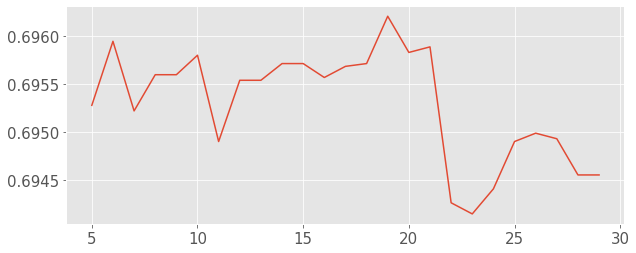

In [70]:
plt.plot(n, score)

In [71]:
print(score.max())

0.6962022186711307


отбор 2

In [72]:
def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

In [73]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [74]:
X['created'] = (X['created'] - X['created'].min()).dt.total_seconds() / (X['created'].max() - X['created'].min()).total_seconds()

In [75]:
X['latitude'] = minmax(X['latitude'])
X['longitude'] = minmax(X['longitude'])
X['price'] = minmax(X['price'])

In [76]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()

0.6954206713322395

In [77]:
n = np.arange(5, 30)
score = np.zeros(n.size)

for num, val in enumerate(n):
    X_best = SelectKBest(f_classif, k=val).fit_transform(X, y)
    score[num] = cross_val_score(LogisticRegression(), X_best, y, scoring='accuracy').mean()

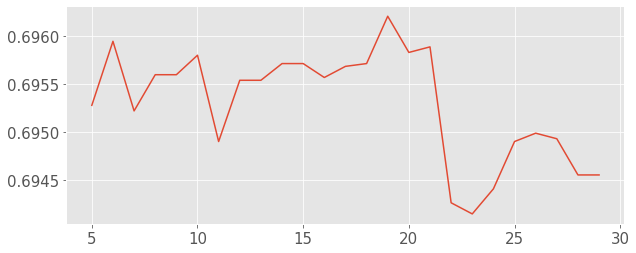

In [78]:
plt.plot(n, score)

In [79]:
print(score.max())

0.6962022186711307


In [80]:
d = np.arange(0, 1, 0.1)
score = np.zeros(d.size)

for num, val in enumerate(d):
    X_varth = VarianceThreshold(val).fit_transform(X)
    score[num] = cross_val_score(LogisticRegression(), X_best, y, scoring='accuracy').mean()

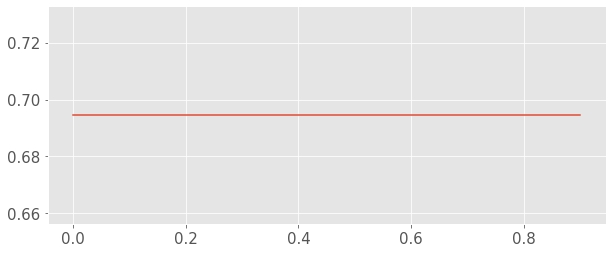

In [81]:
plt.plot(d, score)

In [82]:
print(score.max())

0.6945522388528648


регуляризация

In [161]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [162]:
X['created'] = (X['created'] - X['created'].mean()).dt.total_seconds() / X['created'].std().total_seconds()

In [163]:
X['latitude'] = normalization(X['latitude'])
X['longitude'] = normalization(X['longitude'])
X['price'] = normalization(X['price'])

In [164]:
cross_val_score(LogisticRegression(penalty='l2'), X, y, scoring='accuracy').mean()

0.6988652649839687

комбинирование

In [173]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [174]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathrooms              34546 non-null  float64       
 1   bedrooms               34546 non-null  int64         
 2   created                34546 non-null  datetime64[ns]
 3   latitude               34546 non-null  float64       
 4   longitude              34546 non-null  float64       
 5   price                  34546 non-null  int64         
 6   garden/patio           34546 non-null  float64       
 7   cats allowed           34546 non-null  float64       
 8   laundry room           34546 non-null  float64       
 9   doorman                34546 non-null  float64       
 10  dishwasher             34546 non-null  float64       
 11  exclusive              34546 non-null  float64       
 12  hardwood floors        34546 non-null  float64       
 13  f

In [175]:
X['price_per_room'] = X['price'] / (X['bedrooms'] + X['bathrooms'])
X['price_per_room'][X['price_per_room'] == np.inf] = np.NaN
X['price_per_room'] = X['price_per_room'].fillna(X['price_per_room'][X['price_per_room'].notna()].mean())

In [176]:
X['laundry'] = X['laundry room'] + X['laundry in unit'] + X['laundry in building']
X['prewar'] = X['pre-war'] + X['prewar']
X['pets'] = X['cats allowed'] + X['dogs allowed']
X = X.drop(['laundry room', 'laundry in unit', 'laundry in building', 'pre-war', 'cats allowed',
            'dogs allowed'], axis=1)

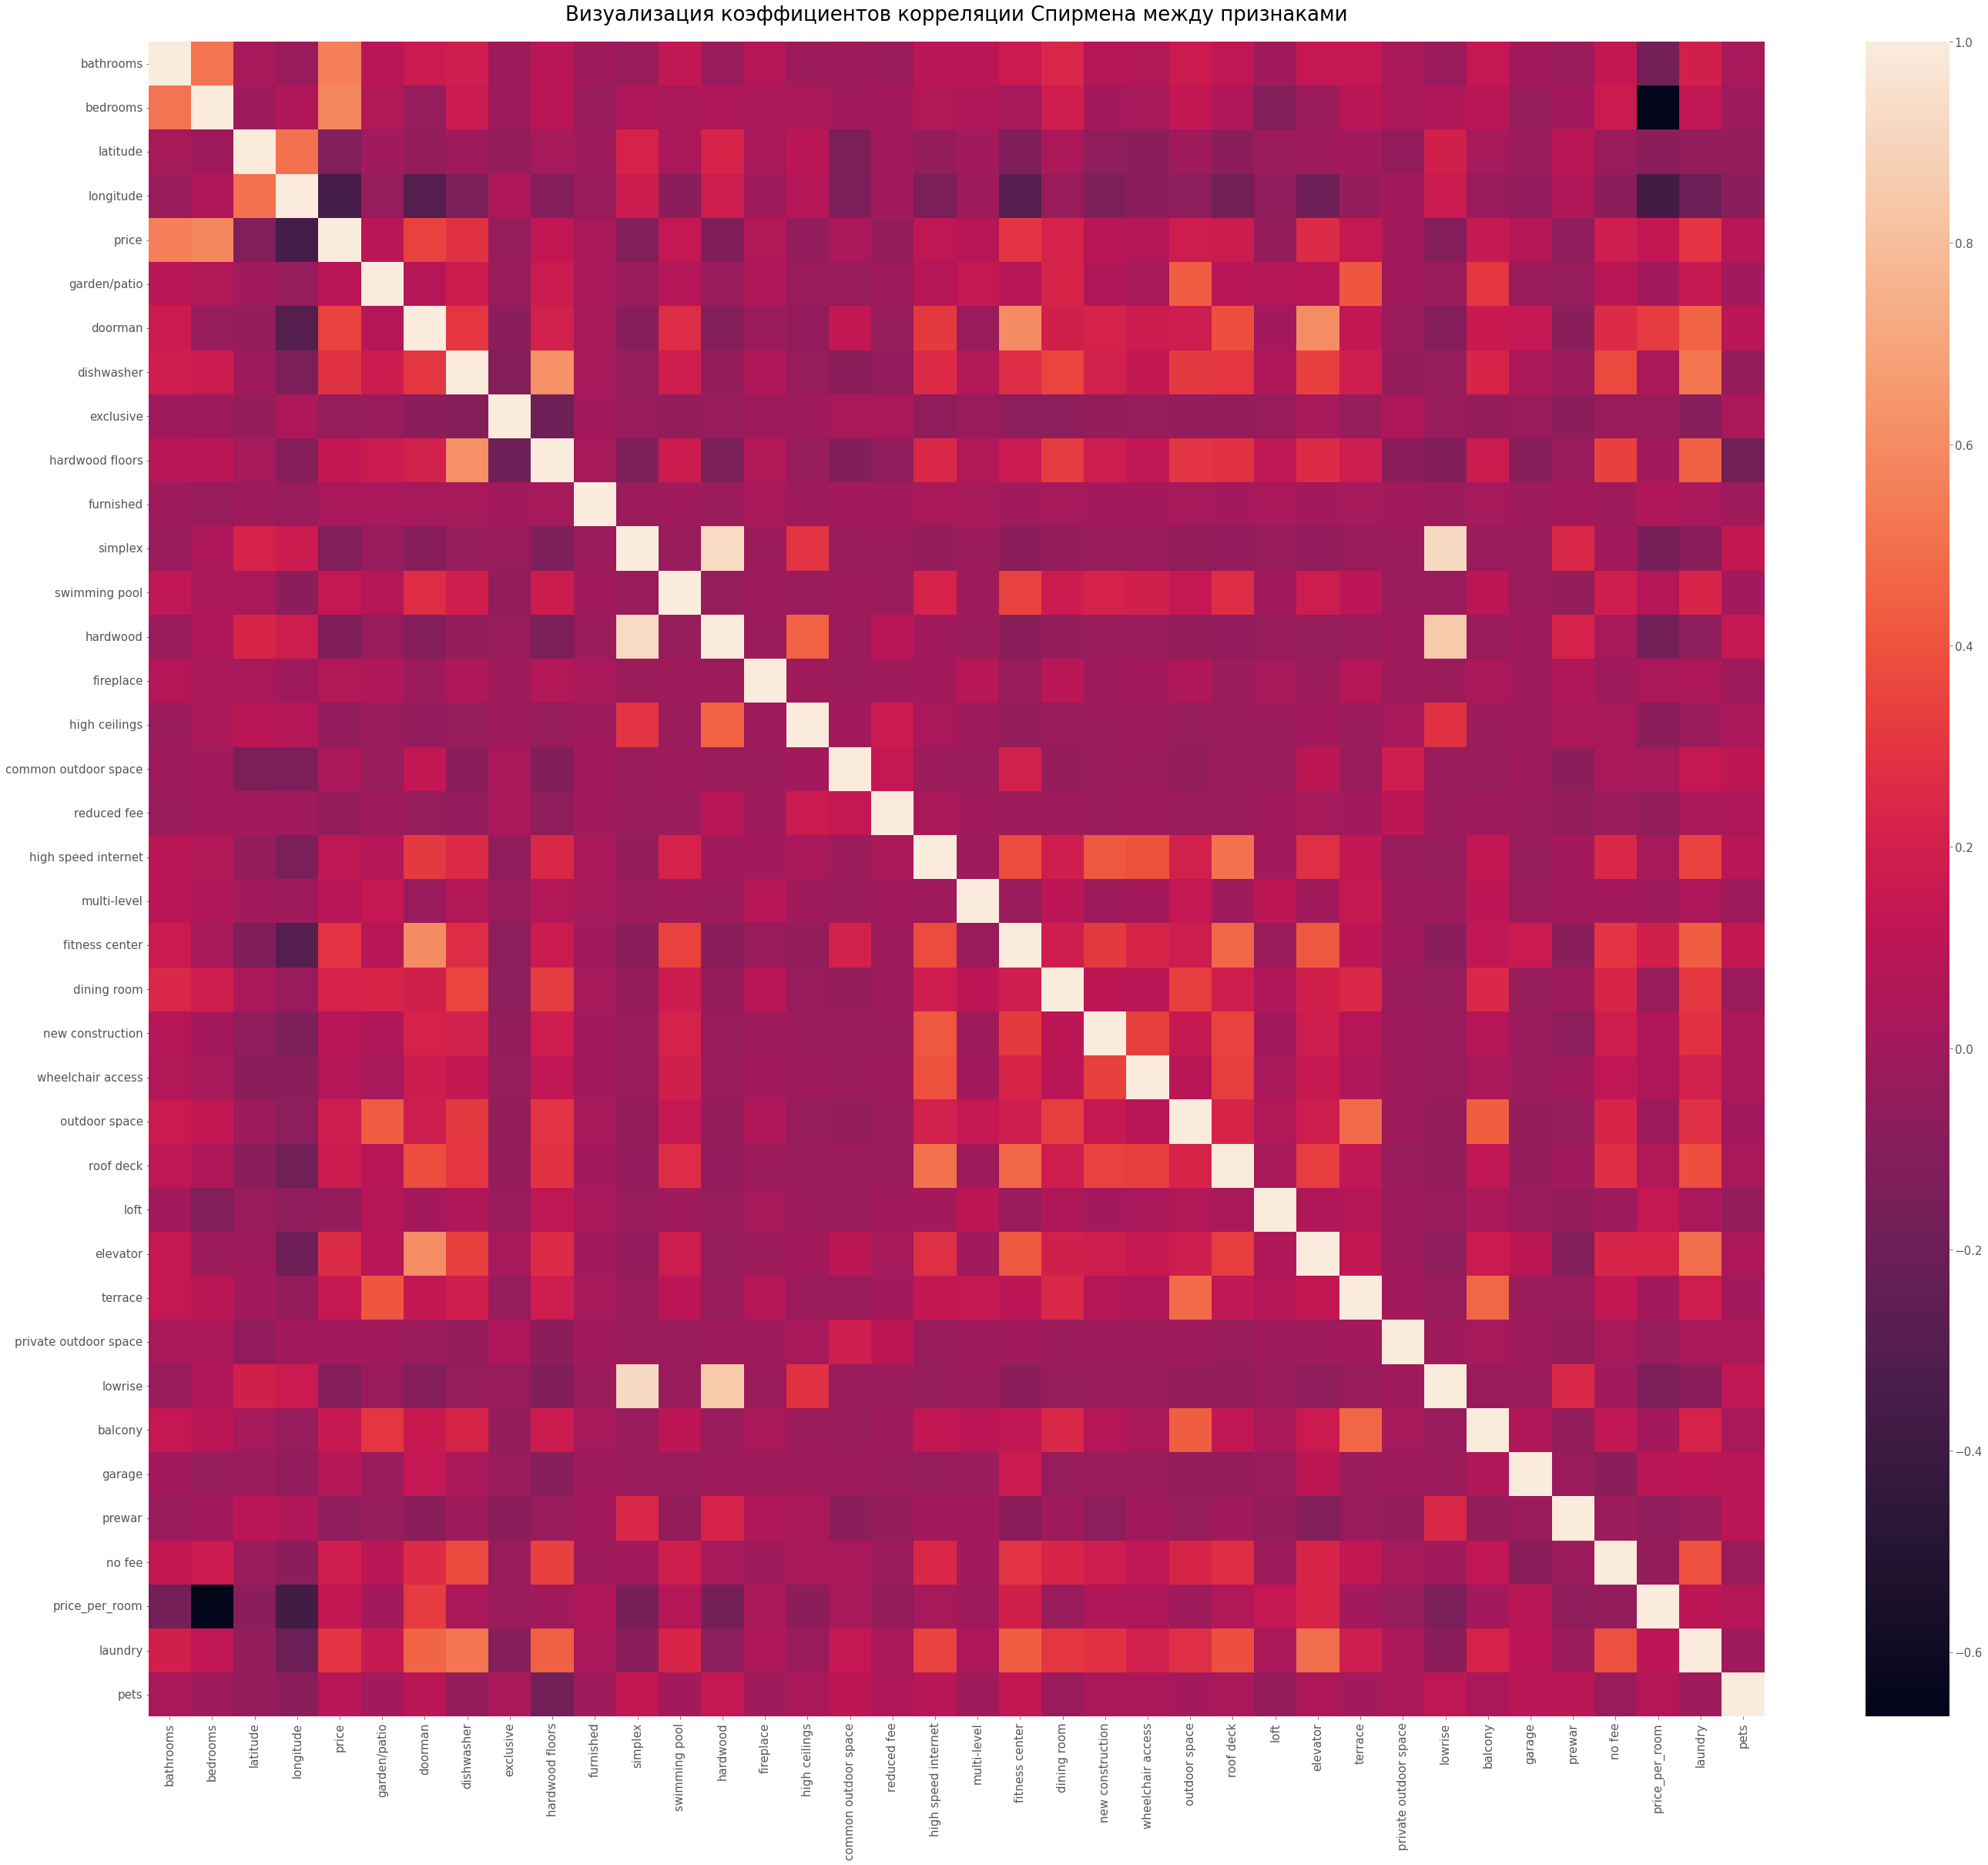

In [177]:
import seaborn as sns
plt.figure(figsize=(47, 40))
sns.heatmap(X.corr(method='spearman'))
plt.title('Визуализация коэффициентов корреляции Спирмена между признаками', y=1.01, size=26)
plt.show()

In [178]:
X['pb'] = X['price_per_room'] / X['bedrooms']
X['pb'][X['pb'] == np.inf] = np.NaN
X['pb'] = X['pb'].fillna(X['pb'][X['pb'].notna()].mean())

In [179]:
X['created'] = (X['created'] - X['created'].mean()).dt.total_seconds() / X['created'].std().total_seconds()

In [180]:
X['latitude'] = normalization(X['latitude'])
X['longitude'] = normalization(X['longitude'])
X['price'] = normalization(X['price'])
X['price_per_room'] = normalization(X['price_per_room'])
X['pb'] = normalization(X['pb'])

In [181]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()

0.7012100159212622

In [182]:
reg = LogisticRegression().fit(X, y)

предсказание

In [183]:
df = pd.read_csv('test.csv') #файл со страницы соревнования
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14806 entries, 0 to 14805
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               14806 non-null  object 
 1   bathrooms        14806 non-null  float64
 2   bedrooms         14806 non-null  int64  
 3   building_id      14806 non-null  object 
 4   created          14806 non-null  object 
 5   description      14397 non-null  object 
 6   display_address  14759 non-null  object 
 7   features         14806 non-null  object 
 8   latitude         14806 non-null  float64
 9   listing_id       14806 non-null  int64  
 10  longitude        14806 non-null  float64
 11  manager_id       14806 non-null  object 
 12  photos           14806 non-null  object 
 13  price            14806 non-null  int64  
 14  street_address   14800 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 1.7+ MB


In [184]:
df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,low,2.0,3,87c4e08083ac83618dd9fdbf849331fe,2016-06-21 03:21:59,Rent listed is net effective after one month f...,E 77 St.,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7716,7189305,-73.9544,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7189305_f47ed5c...,4675,339 E 77 St.
1,low,1.0,2,850c3d4412aebb3335273ed95f3e4bd4,2016-06-11 03:47:06,A FABULOUS 2BR IN THE UPPER EAST SIDE! PERFECT...,E 112 Street,[],40.7944,7140670,-73.9401,3e9f0fa34d67e5d61aae56776ecb8cee,['https://photos.renthop.com/2/7140670_6c5824f...,2100,252 E 112 Street
2,low,1.0,2,84ddf917a091828ab9baedc0c926470e,2016-04-17 02:45:19,This is a great true 2 bedroom in a prime Midt...,Ninth Avenue,"['Dogs Allowed', 'Cats Allowed']",40.7650,6886239,-73.9882,10b1ae0a38d50b7ba0cee612d14af9eb,['https://photos.renthop.com/2/6886239_533bbee...,2800,783 Ninth Avenue
3,high,2.0,3,315a2f868a195b076e5be73411110da2,2016-05-07 11:44:35,Brand new custom renovation in beautiful three...,East 12th street,"['Laundry In Unit', 'No Fee', 'Washer/Dryer in...",40.7288,6981146,-73.9808,e9920062e07ee893c10e38d0259665b0,['https://photos.renthop.com/2/6981146_f4a7400...,5500,186 Avenue B
4,medium,1.0,3,9b525bacc8d294728c35f27c04e22f46,2016-06-24 07:33:26,"Welcome Home! Located on a Prime UWS Block, Ba...",West 86th&Columbus,"['Private Outdoor Space', 'Elevator', 'Laundry...",40.7864,7210864,-73.9713,6d389fbe372d4d30b17733caa9370f95,['https://photos.renthop.com/2/7210864_e8528f4...,3995,47 West 86th street


In [185]:
df = df.drop(['photos', 'manager_id', 'listing_id', 'display_address', 'building_id', 'description', 'Id', 'street_address'], axis=1)
df.head()

,bathrooms,bedrooms,created,features,latitude,longitude,price
0,2.0,3,2016-06-21 03:21:59,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7716,-73.9544,4675
1,1.0,2,2016-06-11 03:47:06,[],40.7944,-73.9401,2100
2,1.0,2,2016-04-17 02:45:19,"['Dogs Allowed', 'Cats Allowed']",40.7650,-73.9882,2800
3,2.0,3,2016-05-07 11:44:35,"['Laundry In Unit', 'No Fee', 'Washer/Dryer in...",40.7288,-73.9808,5500
4,1.0,3,2016-06-24 07:33:26,"['Private Outdoor Space', 'Elevator', 'Laundry...",40.7864,-73.9713,3995


In [186]:
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

In [187]:
df['features'] = df['features'].str.replace(r'\[||\'||\'||\]', '').str.split(', ')

In [188]:
for home in df['features']:
    for feature in home:
        features.add(feature.lower())
features.remove('')

In [189]:
from tqdm.notebook import tqdm
for feature in tqdm(features):
    df[feature] = np.zeros(df['features'].size)
    for num, home in enumerate(df['features']):
        for i in home:
            i = i.lower()
            if i == feature:
                df[feature][num] = 1
                break
    if df[feature].values.sum() < 0.01 * df[feature].size: df = df.drop([feature], axis=1)
df = df.drop(['features'], axis=1)

  0%|          | 0/1294 [00:00<?, ?it/s]

In [190]:
X = df

In [191]:
X['price_per_room'] = X['price'] / (X['bedrooms'] + X['bathrooms'])
X['price_per_room'][X['price_per_room'] == np.inf] = np.NaN
X['price_per_room'] = X['price_per_room'].fillna(X['price_per_room'][X['price_per_room'].notna()].mean())

In [192]:
X['laundry'] = X['laundry room'] + X['laundry in unit'] + X['laundry in building']
X['prewar'] = X['pre-war'] + X['prewar']
X['pets'] = X['cats allowed'] + X['dogs allowed']
X = X.drop(['laundry room', 'laundry in unit', 'laundry in building', 'pre-war', 'cats allowed',
            'dogs allowed'], axis=1)

In [193]:
X['pb'] = X['price_per_room'] / X['bedrooms']
X['pb'][X['pb'] == np.inf] = np.NaN
X['pb'] = X['pb'].fillna(X['pb'][X['pb'].notna()].mean())

In [194]:
X['created'] = (X['created'] - X['created'].mean()).dt.total_seconds() / X['created'].std().total_seconds()

In [195]:
X['latitude'] = normalization(X['latitude'])
X['longitude'] = normalization(X['longitude'])
X['price'] = normalization(X['price'])
X['price_per_room'] = normalization(X['price_per_room'])
X['pb'] = normalization(X['pb'])

In [196]:
target = reg.predict(X)

In [197]:
df = pd.read_csv('sample_submission.csv')

In [198]:
df['TARGET'] = target

In [199]:
df.to_csv('submission.csv', index=False)